In [ ]:
#Pacote para aquisição do banco de dados imdb

!pip install imdb-sqlite

In [ ]:
!pip install pycountry

In [11]:
!pip install seaborn==0.11.0

In [221]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [222]:
%%time
!imdb-sqlite

Wall time: 14.3 s


2021-08-17 11:05:47,511 DB already exists: (imdb.db). Refusing to modify. Exiting


In [223]:
conn = sqlite3.connect("imdb.db")

In [224]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [225]:
type(tabelas)

pandas.core.frame.DataFrame

In [226]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [227]:
tabelas = tabelas["Table_Name"].values.tolist()

In [228]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema de tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema de tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema de tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema de tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema de tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema de tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema de tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# 1 - Quais são as categorias de Filmes mais comuns no IMDB?

In [229]:
# Cria a consulta SQL

consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type''' 

In [230]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [231]:
display(resultado1)

,type,COUNT
0,movie,585071
1,radioEpisode,1
2,radioSeries,1
3,short,825870
4,tvEpisode,5986490
5,tvMiniSeries,38865
6,tvMovie,132533
7,tvSeries,212675
8,tvShort,10206
9,tvSpecial,33730


In [232]:
# Resultado em percentual para cada tipo

resultado1['percentual'] = (resultado1['COUNT']/ resultado1['COUNT'].sum()) * 100

In [233]:
display(resultado1)

,type,COUNT,percentual
0,movie,585071,7.159421
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,825870,10.106041
4,tvEpisode,5986490,73.255733
5,tvMiniSeries,38865,0.475585
6,tvMovie,132533,1.621785
7,tvSeries,212675,2.602470
8,tvShort,10206,0.124889
9,tvSpecial,33730,0.412749


In [234]:
others = {}

# Filtra o percentual em 5% e soma o total

others['COUNT'] = resultado1[resultado1['percentual']<5]['COUNT'].sum()

# Grava o percentual

others['percentual'] = resultado1[resultado1['percentual']<5]['percentual'].sum()

# Ajusta o nome

others['type'] = 'others'


In [235]:
others

{'COUNT': 774612, 'percentual': 9.478804749314218, 'type': 'others'}

In [236]:
resultado1 = resultado1[resultado1['percentual']>5]

In [237]:
resultado1 = resultado1.append(others, ignore_index = True)

In [238]:
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [239]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,5986490,73.255733
1,short,825870,10.106041
3,others,774612,9.478805
0,movie,585071,7.159421


In [240]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2))+'%'+']' for i in resultado1.index]

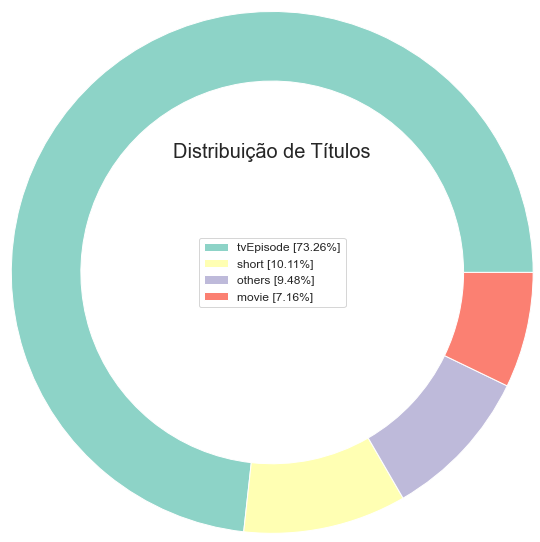

In [241]:
#Plotando

cs = cm.Set3(np.arange(100))

# Cria a figura

f = plt.figure()

# Pie plot

plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title('Distribuição de Títulos', loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()  

# 2 - Qual o número de títulos por gênero?

In [242]:
# Criando a consulta SQL (Sintaxe SQL, Letra maiúscula)

consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [243]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [244]:
# Visualiza o resultado2

display(resultado2)

,genres,COUNT(*)
0,Action,13313
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1439,"Thriller,Western",39
1440,War,1249
1441,"War,Western",9
1442,Western,4014


In [245]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [246]:
temp = resultado2['genres'].dropna()

In [247]:
display(resultado2)

,genres,COUNT(*)
0,action,13313
1,"action,adult",11
2,"action,adult,adventure",1
3,"action,adult,comedy",5
4,"action,adult,crime",10
...,...,...
1439,"thriller,western",39
1440,war,1249
1441,"war,western",9
1442,western,4014


In [248]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [249]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [250]:
bag_generos = vetor.transform(temp)

In [251]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [252]:
generos_unicos = vetor.get_feature_names()

In [253]:
generos = pd.DataFrame(bag_generos.todense(),columns = generos_unicos, index = temp.index)

In [254]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1443
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1444 non-null   int64
 1   adult        1444 non-null   int64
 2   adventure    1444 non-null   int64
 3   animation    1444 non-null   int64
 4   biography    1444 non-null   int64
 5   comedy       1444 non-null   int64
 6   crime        1444 non-null   int64
 7   documentary  1444 non-null   int64
 8   drama        1444 non-null   int64
 9   family       1444 non-null   int64
 10  fantasy      1444 non-null   int64
 11  film-noir    1444 non-null   int64
 12  game-show    1444 non-null   int64
 13  history      1444 non-null   int64
 14  horror       1444 non-null   int64
 15  music        1444 non-null   int64
 16  musical      1444 non-null   int64
 17  mystery      1444 non-null   int64
 18  n            1444 non-null   int64
 19  news         1444 non-null   int64
 20  reality-

In [255]:
generos = generos.drop(columns = 'n', axis = 0)

In [256]:
generos_percentual = 100 * pd.Series(generos.sum().sort_values(ascending = False)/generos.shape[0])

In [257]:
generos_percentual.head(10)

drama          18.421053
comedy         16.828255
documentary    15.997230
adventure      14.889197
action         14.612188
romance        13.504155
crime          13.019391
mystery        12.603878
thriller       12.396122
fantasy        12.257618
dtype: float64

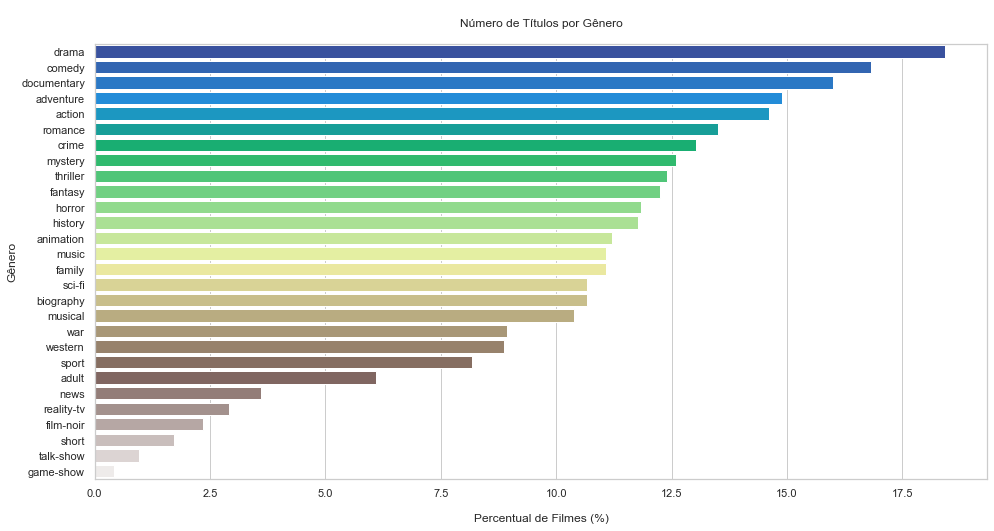

In [258]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero de Títulos por Gênero\n')
plt.show()

# 3 - Qual a Mediana de avaliação dos filmes por gênero?

In [259]:
#Utilizamos a mediana para encontrar o valor "do meio" da distribuição
#A média é afetadas por outliers (valores extremos) e a mediana não.

consulta3 = '''
            SELECT rating, genres FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [260]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [261]:
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
267053,3.5,"Action,Adventure,Thriller"
267054,5.8,Thriller
267055,6.3,"Adventure,Drama,History"
267056,3.8,"Adventure,History,War"


In [262]:
# Função criada para retornar os gêneros

def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre)>1]
    return generos_unicos

In [263]:
# Aplicando a função

generos_unicos = retorna_generos(resultado3)

In [264]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [265]:
#Listas vazias para a contagem

genero_counts = []
genero_ratings = []

In [266]:
for item in generos_unicos:
    
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE'+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE'+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [267]:
# Preparando o dataframe final

df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres']=generos_unicos
df_genero_ratings['count']=genero_counts
df_genero_ratings['rating']=genero_ratings


In [268]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28710,5.8
1,adult,4075,5.8
2,adventure,17642,6.0
3,animation,4662,6.4
4,biography,8029,7.0
5,comedy,66602,6.0
6,crime,23041,6.1
7,documentary,39090,7.3
8,drama,118558,6.3
9,family,10157,6.3


In [269]:
#Drop índice 18 (news)
#Não queremos essa informação como gênero

df_genero_ratings = df_genero_ratings.drop(index=18)

In [270]:
df_genero_ratings = df_genero_ratings.sort_values(by='rating',ascending=False)

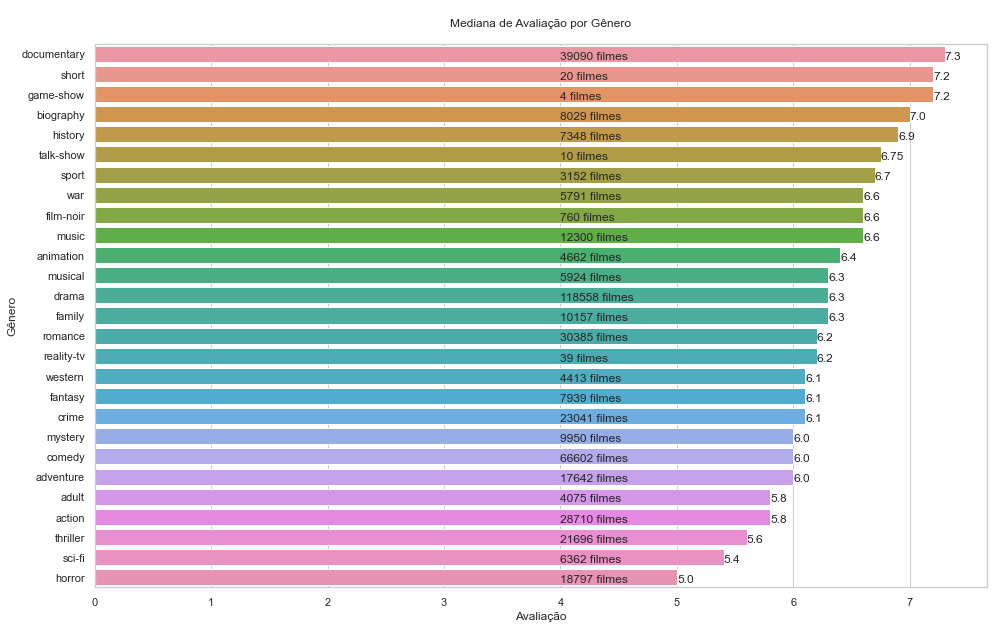

In [271]:
plt.figure(figsize=(16,10))

sns.barplot(y=df_genero_ratings.genres, x=df_genero_ratings.rating, orient="h")

# Textos do gráfico

for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
            i + 0.25,
            str(df_genero_ratings['count'][df_genero_ratings.index[i]])+ " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
            i + 0.25,
            round(df_genero_ratings["rating"][df_genero_ratings.index[i]], 2))
    
plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana de Avaliação por Gênero\n')
plt.show()

# 4 - Qual a Mediana de avaliação dos filmes em relação ao ano de estréia?

In [272]:
consulta4 = '''
            SELECT rating AS Rating,premiered FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [273]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [274]:
display(resultado4)

,Rating,premiered
0,4.5,1905
1,6.1,1906
2,5.2,1907
3,4.5,1907
4,3.8,1908
...,...,...
267053,3.5,2020
267054,5.8,2020
267055,6.3,2020
267056,3.8,2019


In [275]:
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered']==year]['Rating']))

In [276]:
type(ratings)

list

In [277]:
ratings[1:10]

[4.6, 4.9, 4.05, 6.3, 4.8, 3.6, 4.9, 5.4, 4.5]

In [278]:
#Criando lista de anos para utlizar no gráfico

anos = list(set(resultado4['premiered']))

In [279]:
anos[1:10]

[1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905]

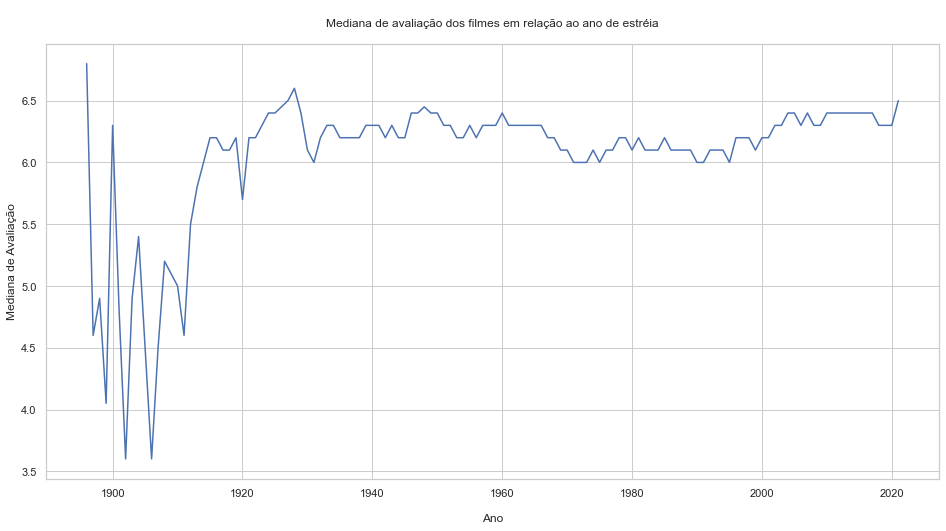

In [280]:
plt.figure(figsize=(16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de avaliação dos filmes em relação ao ano de estréia\n')
plt.show()

# 5 - Qual o número de filmes avaliados por gênero em relação ao ano de estréia?

In [281]:
consulta5 = '''SELECT genres FROM titles'''

In [282]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [283]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8172038,"Action,Drama,Family"
8172039,"Action,Drama,Family"
8172040,"Action,Drama,Family"
8172041,Short


In [284]:
generos_unicos = retorna_generos(resultado5)

In [285]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [287]:
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [288]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [290]:
# Cálculo do TOP 5

df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

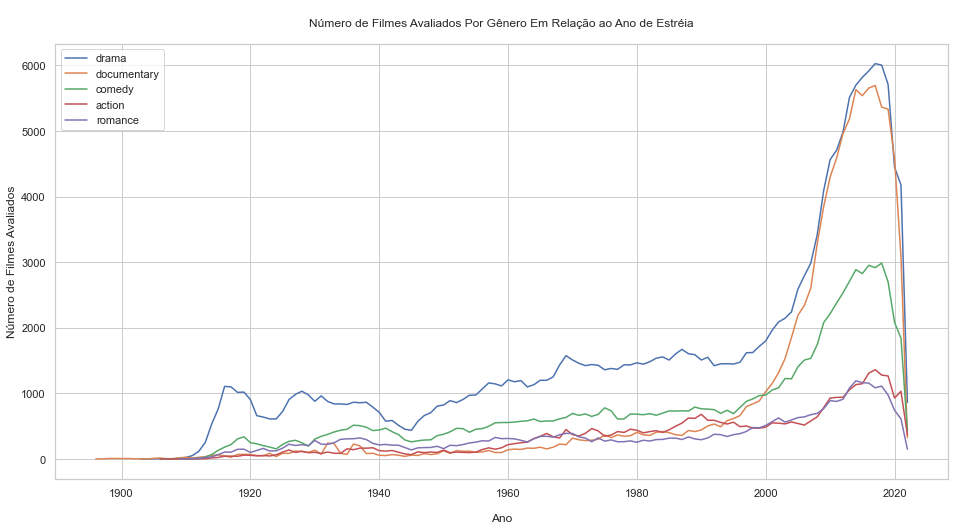

In [291]:
plt.figure(figsize = (16,8))

for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

# 6 - Qual o filme com maior tempo de duração?

In [294]:
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

In [295]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [296]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
368411,123
368412,57
368413,100
368414,116


In [297]:
# Calculando os percentis apenas a titulo de curiosidade, não são necessários para responder nosso questionamento.

for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [298]:
#Temos um outlier, referente ao percentil 100
#Refazendo a consulta e retornando o filme com maior duração

consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''

In [299]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [300]:
resultado6

,Runtime,primary_title
0,51420,Logistics


# 7 - Qual a relação entre duração e gênero?

In [303]:
# Função AVG calcula a média

consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [304]:
resultado7=pd.read_sql_query(consulta7, conn)

In [305]:
#Relembrando, utilizando a função criada que retorna gêneros únicos

generos_unicos = retorna_generos(resultado7)

In [306]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [307]:
#Calculando a duração por gênero

genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [308]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [309]:
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [310]:
#Ordenando os dados

df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

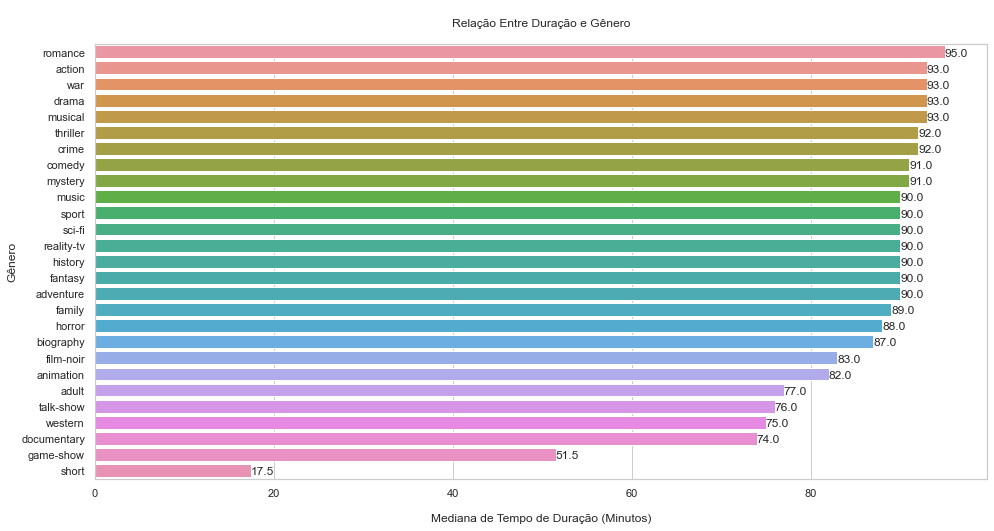

In [311]:
# Para maior entendimento do uso da mediana, consultar as diferenças entre média e mediana.

plt.figure(figsize = (16,8))

sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# 8 - Qual o número de filmes produzidos por país?

In [333]:
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [334]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [338]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,337
2,AF,108
3,AG,12
4,AL,1232
...,...,...
229,YUCS,146
230,ZA,3020
231,ZM,11
232,ZRCD,2


In [339]:
resultado8.shape

(234, 2)

In [340]:
resultado8.shape[0]

234

In [341]:
nomes_paises = []
contagem = []

In [342]:
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]     
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [343]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [344]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [345]:
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,261202
65,United Kingdom,118369
96,Japan,88491
63,France,81488
89,India,72874
32,Canada,69157
47,Germany,65957
93,Italy,63426
26,Brazil,62276
58,Spain,62080


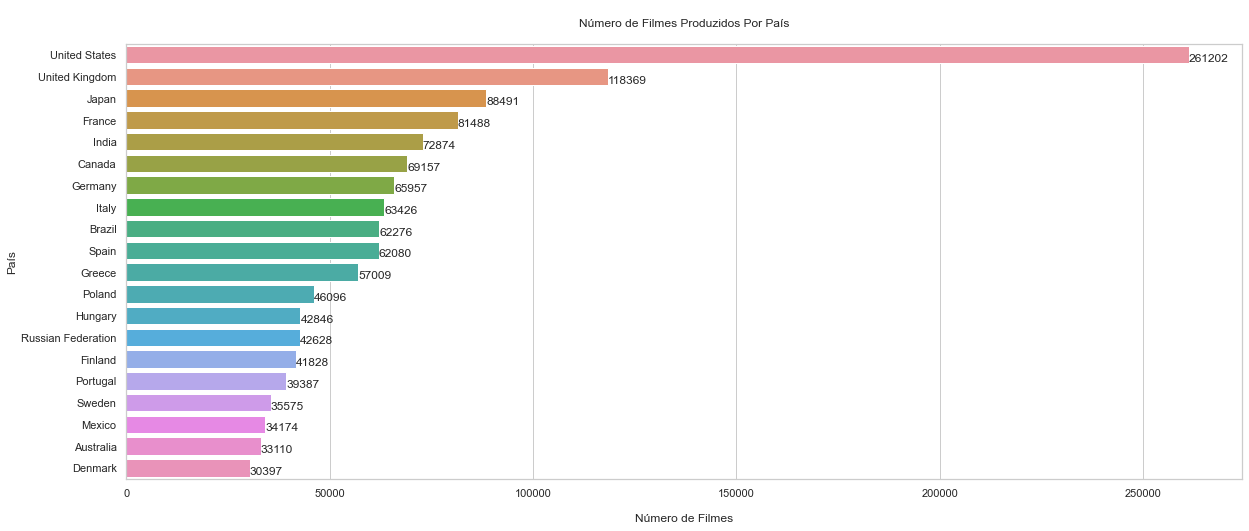

In [346]:
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# 9 - Quais são os TOP 10 melhores filmes?

In [347]:
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [348]:
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [349]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


# 10 - Quais são os TOP 10 piores filmes?

In [350]:
# O que muda em relação aos melhores é apenas o parametro ASC e DESC na query

consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [351]:
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [352]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
